# Assignment 4: Block Matching and Harris Corner Detection
## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color, filters
import cv2
import numpy as np

def blockMatching(image1, image2, ws, threshold):
    height, width = image1.shape
    
    originToTarget = dict()
    
    for y in range(ws, height-ws, 10):
        for x in range(ws, width-ws, 10):
            aoi0 = image1[y-ws:y+ws, x-ws:x+ws]
            
            for dX in range(-ws,ws):
                for dY in range(-ws, ws):
                    cX = x + dX
                    cY = y + dY
                    
                    if 0 > cX > width:
                        continue
                    if 0 > cY > height:
                        continue
                    
                    aoi1 = image2[cY-ws:cY+ws, cX-ws:cX+ws]
                    dif = aoi0 - aoi1
                    dif = np.power(dif, 2)
                    result = np.sum(dif)
                    
                    if result > threshold:
                        originToTarget[(y,x)] = (cY, cX)
                    
    return originToTarget

(480, 640, 3)


ValueError: operands could not be broadcast together with shapes (10,10) (0,0) 

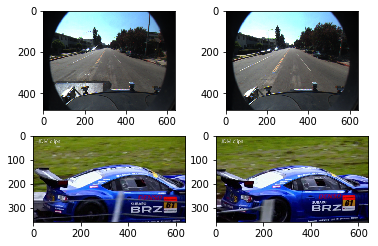

In [2]:
# chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

car1 = io.imread('images/racecar/100.jpeg')
car2 = io.imread('images/racecar/102.jpeg') 

fig = plt.figure(0)
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(car1)
ax22.imshow(car2)

print(lane1.shape)

blockMatching(color.rgb2grey(lane1), color.rgb2grey(lane2), 5, 100)

## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [32]:
def nonMaxSuppression(edges, ws):
    height, width = edges.shape
    
    #suppressed = edges
    suppressed = np.ones_like(edges)
    
    for x in range(1, width):
        for y in range(1, height):
            # suppressed[y,x] = 1 
            
            if np.sum(edges[y-1:y+1, x-1:x+1]) <= 0:
                suppressed[y,x] = 0
                continue
            
            # horizontal
            if edges[y, x-1] > edges[y, x] or edges[y, x+1] > edges[y,x]:
                suppressed[y,x] = 0
            
            # vertical 
            if edges[y-1,x] > edges[y,x] or edges[y+1,x] > edges[y,x]:
                suppressed[y,x] = 0
        
            # diagnoal
            if edges[y-1,x-1] > edges[y,x] or edges[y+1,x+1] > edges[y,x]:
                suppressed[y,x] = 0
                
            # diagnoal
            if edges[y-1,x+1] > edges[y,x] or edges[y+1,x-1] > edges[y,x]:
                suppressed[y,x] = 0
        
    return suppressed


def harrisCorner(image, ws=1):
    imgGrey = color.rgb2grey(image)
    height, width = imgGrey.shape
    
    ix = filters.sobel_h(imgGrey)
    iy = filters.sobel_v(imgGrey)
    
    edges = np.zeros_like(imgGrey)
    
    # mult at each pixel
    ix2 = ix * ix
    iy2 = iy * iy
    ixy = ix * iy
    
    for x in range(ws, width-ws):
        for y in range(ws, height-ws):            
            sx2 = np.sum(ix2[y-ws:y+ws, x-ws:x+ws])
            sy2 = np.sum(iy2[y-ws:y+ws, x-ws:x+ws])
            sxy = np.sum(ixy[y-ws:y+ws, x-ws:x+ws])
            H = np.array( [ [sx2, sxy], [sxy, sy2] ] )
            R = np.linalg.det(H) - (0.04*np.power(np.matrix.trace(H), 2))
            
            edges[y,x] = R if R > 0.005 else 0  #1 if R > 0.005 else 0
            
    return nonMaxSuppression(edges, ws)
    # return edges


def getPointVector(greyScaleImage):
    height, width = greyScaleImage.shape
    points = []
    p0=np.array([[348.0, 251.0]],np.float32)
    for x in range(1, width):
        for y in range(1, height):
            if greyScaleImage[y,x] == 1.0:
                points.append([np.float32(x),np.float32(y)])
    
    # print(points)
    return np.array(points, np.float32)



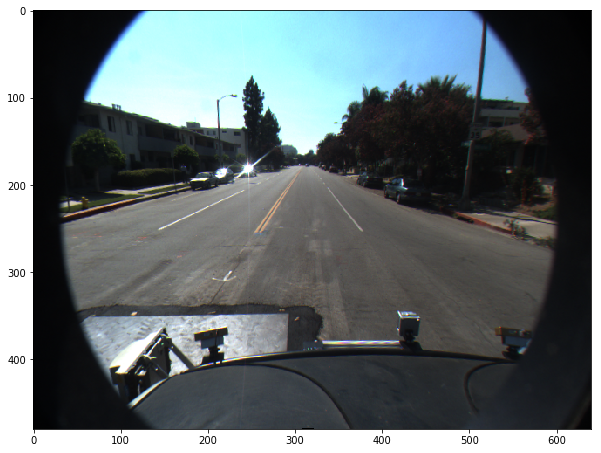

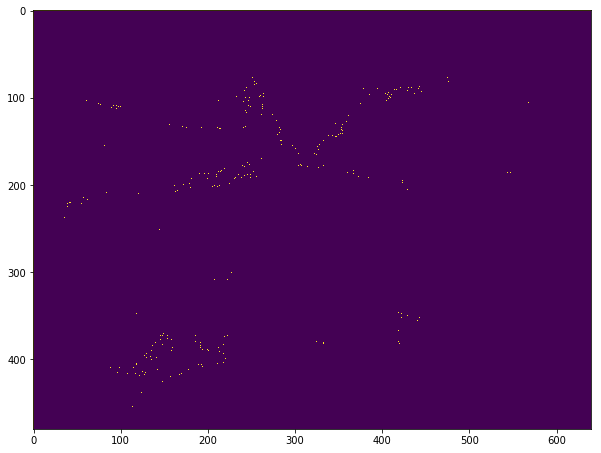

In [37]:
l1 = io.imread('images/lane_detection/f00000.png')
l2 = io.imread('images/lane_detection/f00001.png')

l1Height, l1Width, _ = l1.shape

crop = 50
# l1 = l1[crop:l1Height-crop, crop:l1Width-crop]
# l2 = l2[crop:l1Height-crop, crop:l1Width-crop]

# ref = io.imread('images/reference.png')

res = harrisCorner(l1)

plt.figure(1, figsize=(10, 15))
plt.imshow(l1)

plt.figure(2, figsize=(10, 15))
plt.imshow(res)

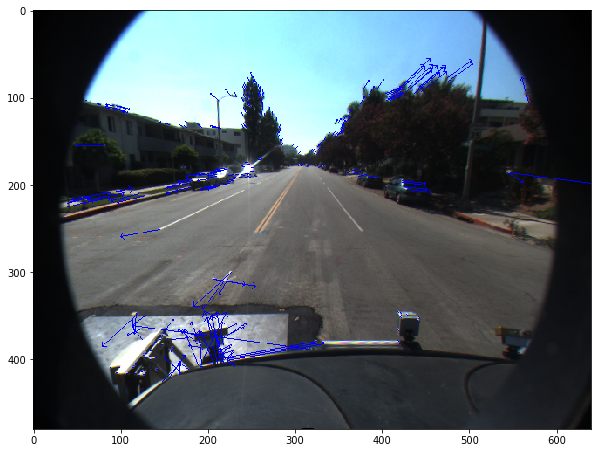

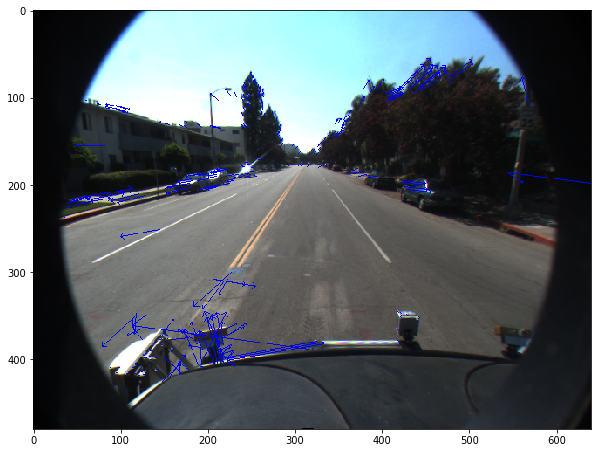

In [39]:
def drawVectors(img, oldPoints, newPoints):
    for i in range (0, len(oldPoints)):
        oldPoint = oldPoints[i]
        newPoint = newPoints[i]
        
        cv2.arrowedLine(img, (oldPoint[0], oldPoint[1]), (newPoint[0], newPoint[1]), (0,0,255))
    return img


points = getPointVector(res)
# nextPoints, _, _ = cv2.calcOpticalFlowPyrLK(l1, l2, points, None, winSize=(50,50))
nextPoints, _, _ = cv2.calcOpticalFlowPyrLK(l1, l2, points, None)

resultImage1 = np.copy(l1)
resultImage1 = drawVectors(resultImage1, points, nextPoints)

resultImage2 = np.copy(l2)
resultImage2 = drawVectors(resultImage2, points, nextPoints)

plt.figure(1, figsize=(10, 15))
plt.imshow(resultImage1)

plt.figure(2, figsize=(10, 15))
plt.imshow(resultImage2)
